In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from mord import LogisticIT

import statsmodels.api as sm

from dmba import classificationSummary, gainsChart, liftChart, plotDecisionTree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor


%matplotlib inline
import matplotlib.pylab as plt

In [1]:
# Data Preprocessing

In [2]:
# Create data frame for Flight Delay data set. 
flight_df = pd.read_csv('FlightDelays.csv')
flight_df.dtypes

SCH_TIME      int64
CARRIER      object
DEP_TIME      int64
DEST         object
DISTANCE      int64
FL_NUM        int64
ORIGIN       object
WEATHER       int64
WK_DAY        int64
MTH_DAY       int64
FL_STATUS    object
dtype: object

In [6]:
# To remove ‘DEST’ and ‘ORIGIN’ variables from the flight_df data frame
flight_df=flight_df.drop(["DEST","ORIGIN"], axis=1)
flight_df.columns

KeyError: "['DEST', 'ORIGIN'] not found in axis"

In [7]:
# To changing the CARRIER and FL_STATUS Variable to Category Type variable 
flight_df.CARRIER = flight_df.CARRIER.astype('category')
flight_df.FL_STATUS = flight_df.FL_STATUS.astype('category')
flight_df.dtypes


SCH_TIME        int64
CARRIER      category
DEP_TIME        int64
DISTANCE        int64
FL_NUM          int64
WEATHER         int64
WK_DAY          int64
MTH_DAY         int64
FL_STATUS    category
dtype: object

In [8]:
# To change CARRIER and FL_STATUS to Dummy Variables.
flight_df = pd.get_dummies(flight_df, columns=['CARRIER', 'FL_STATUS'], drop_first=True)


In [9]:
flight_df.dtypes

SCH_TIME            int64
DEP_TIME            int64
DISTANCE            int64
FL_NUM              int64
WEATHER             int64
WK_DAY              int64
MTH_DAY             int64
CARRIER_DH          uint8
CARRIER_DL          uint8
CARRIER_MQ          uint8
CARRIER_OH          uint8
CARRIER_RU          uint8
CARRIER_UA          uint8
CARRIER_US          uint8
FL_STATUS_ontime    uint8
dtype: object

In [ ]:
# Task 1(a)

In [10]:
predictors = ['SCH_TIME', 'DEP_TIME', 'DISTANCE', 'FL_NUM', 'WEATHER', 'WK_DAY','MTH_DAY', 'CARRIER_DH', 'CARRIER_DL', 
              'CARRIER_MQ', 'CARRIER_OH', 'CARRIER_RU', 'CARRIER_UA', 'CARRIER_US', 'FL_STATUS_ontime']
outcome = 'FL_STATUS_ontime'

# Create predictor X and outcome y variables.  
X = flight_df.drop(columns=['FL_STATUS_ontime'])
y = flight_df['FL_STATUS_ontime']

# Partition data into training and validation data sets
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=1)

# Train a logistic regression model using LogisticRegression() with the training data set
log_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
log_reg.fit(train_X, train_y)


# Show intercept and coefficients of the multiple predictors' logistic model.
print('Parameters:-')
print('Intercept:', np.round(log_reg.intercept_[0], decimals=3))
print()
print('Coefficients:-')
print(pd.DataFrame({'Coeff:': np.round(log_reg.coef_[0], decimals=3)}, 
                    index=X.columns).transpose())


# Logit = 0.097 + 0.027*SCH_TIME - 0.028*DEP_TIME + 0.01*DISTANCE + 0.0*FL_NUM - 0.53*WEATHER + 0.048*WK_DAY - 0.022*MTH_DAY
# + 0.061*CARRIER_DH + 0.708*CARRIER_DL - 0.83*CARRIER_MQ + 0.375*CARRIER_OH - 0.012*CARRIER_RU + 0.074*CARRIER_UA
# - 0.042*CARRIER_US

Parameters:-
Intercept: 0.097

Coefficients:-
        SCH_TIME  DEP_TIME  DISTANCE  FL_NUM  WEATHER  WK_DAY  MTH_DAY  \
Coeff:     0.027    -0.028      0.01     0.0    -0.53   0.048   -0.022   

        CARRIER_DH  CARRIER_DL  CARRIER_MQ  CARRIER_OH  CARRIER_RU  \
Coeff:       0.061       0.708       -0.83       0.375      -0.012   

        CARRIER_UA  CARRIER_US  
Coeff:       0.074      -0.042  


In [11]:
# Task 1(b)

In [12]:
# Predict results (0 or 1) for validation set.
log_pred = log_reg.predict(valid_X)

# Predict probabilities p(0) and p(1) for validation set.
log_prob = np.round(log_reg.predict_proba(valid_X), decimals=4)

# To display results for validation set. 
log_result = pd.DataFrame({'Actual': valid_y, 
                        'Classification': log_pred,     
                        'p(0)': [p[0] for p in log_prob],
                        'p(1)': [p[1] for p in log_prob],
                        })



print(log_result.head(50))


      Actual  Classification    p(0)    p(1)
1276       1               1  0.1387  0.8613
1446       1               1  0.0810  0.9190
335        1               1  0.0760  0.9240
1458       1               1  0.1252  0.8748
2038       1               1  0.0988  0.9012
1314       1               1  0.0772  0.9228
389        1               1  0.1252  0.8748
1639       1               1  0.1276  0.8724
2004       1               1  0.1063  0.8937
403        1               1  0.2628  0.7372
979        1               1  0.0610  0.9390
65         1               1  0.0806  0.9194
2105       1               1  0.1460  0.8540
1162       1               1  0.1355  0.8645
572        1               1  0.2801  0.7199
1026       0               1  0.0696  0.9304
1044       1               1  0.4224  0.5776
1846       0               1  0.4180  0.5820
1005       1               1  0.1401  0.8599
1677       1               1  0.0710  0.9290
857        1               1  0.1012  0.8988
1539      

In [45]:
# Task 1(c)

In [12]:
# Identify  and display confusion matrix for training partition. 
print('Training Data Set')
classificationSummary(train_y, log_reg.predict(train_X))

# Identify and display confusion matrix for validation partition. 
print()
print('Validation Data Set')
classificationSummary(valid_y, log_reg.predict(valid_X))

Training Data Set
Confusion Matrix (Accuracy 0.8994)

       Prediction
Actual    0    1
     0  173  173
     1    4 1410

Validation Data Set
Confusion Matrix (Accuracy 0.8934)

       Prediction
Actual   0   1
     0  35  47
     1   0 359


In [13]:
# Task 1(d)

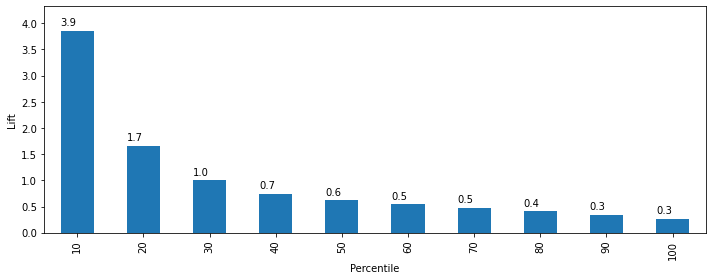

In [14]:
# Create a new df data frame from log_result data frame that is sorted by p(0) in descending order.  
df = log_result.sort_values(by=['p(0)'], ascending=False)

# Create a data plot with two plots (ncols=1) back-to-back (nrows=1).
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

# Using liftChart() function, create decile-wise Lift chart. 
liftChart(df['p(0)'], title=False)
 
# Display the charts. 
plt.tight_layout()
plt.show()


In [13]:
# Task 2(a)

In [14]:
# Improving grid search parameters.
parameters_grid = {
    'max_depth': list(range(2, 30)),  
    'min_impurity_decrease': [0, 0.0005, 0.001], 
    'min_samples_split': list(range(5, 30)),
}

# Apply GridSearchCV() fucntion for various combinations of DecisionTreeClassifier() improved parameters. 
gridSearch = GridSearchCV(DecisionTreeClassifier(), 
                parameters_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print(f'Improved score:{gridSearch.best_score_:.4f}')
print('Improved parameters: ', gridSearch.best_params_)

Improved score:0.8858
Improved parameters:  {'max_depth': 9, 'min_impurity_decrease': 0.001, 'min_samples_split': 20}


Classification Tree


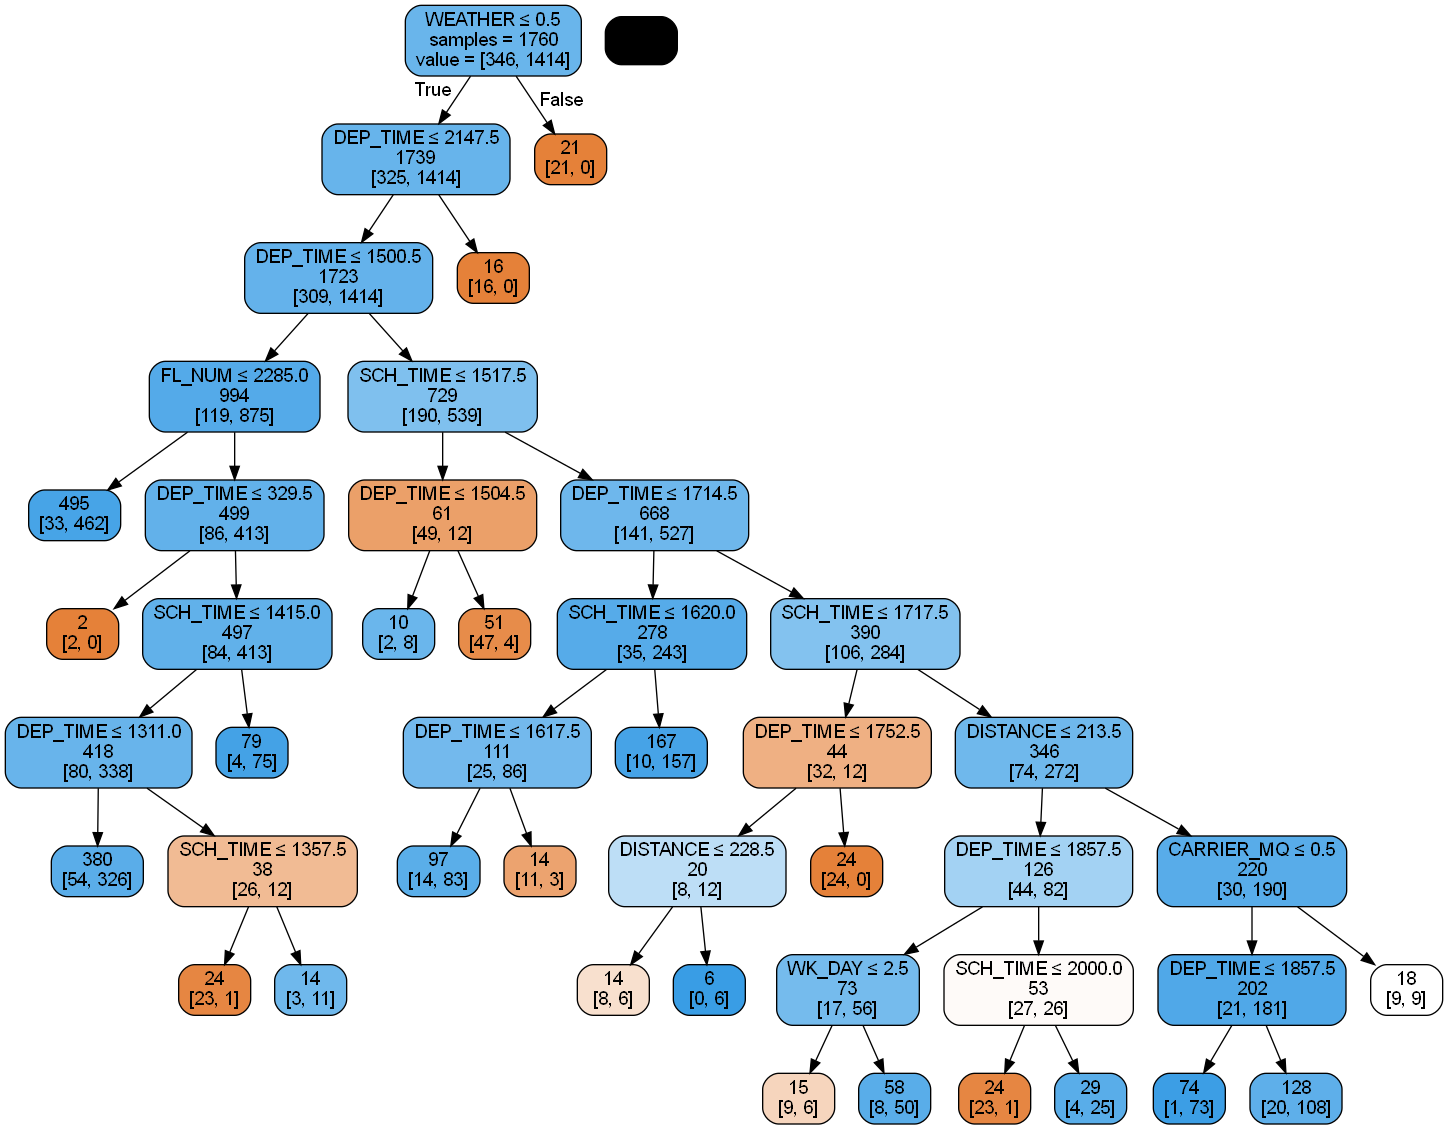

In [15]:
# To create and display classification tree based on the improved parameters.
bestClassTree = gridSearch.best_estimator_

print('Classification Tree')
plotDecisionTree(bestClassTree, feature_names=train_X.columns)


In [16]:
# Confusion matrices for grid search classification tree. 

# To display confusion matrix for training partition. 
classificationSummary(train_y, bestClassTree.predict(train_X))

# To display confusion matrix for validation partition. 
classificationSummary(valid_y, bestClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8960)

       Prediction
Actual    0    1
     0  193  153
     1   30 1384
Confusion Matrix (Accuracy 0.8685)

       Prediction
Actual   0   1
     0  42  40
     1  18 341
